# Importing Libraries

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
import warnings
warnings.filterwarnings('ignore')

# Loading Data

In [2]:
data = pd.read_csv('data/expression_data.csv')
data.head()

,Unnamed: 0,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,...,ENSG00000272414,ENSG00000272442,ENSG00000272658,ENSG00000272869,ENSG00000273079,ENSG00000273173,ENSG00000273259,ENSG00000273274,ENSG00000273294,Simplified_class
0,DLDR_0001,5.965571,1.612375,4.133821,4.111056,4.150662,2.975845,11.005488,4.405768,6.825329,...,-0.005377,1.546032,1.365460,0.691230,5.637483,-0.005377,1.675800,2.683536,-0.339797,Normal
1,DLDR_0002,5.741587,2.147793,4.120969,3.922234,3.732756,3.199989,10.860700,3.895350,6.453687,...,-0.515172,1.806756,0.935490,1.004202,5.975612,0.532134,1.555218,2.926666,0.435919,Normal
2,DLDR_0003,5.996891,0.418542,4.086129,3.964871,3.634637,2.949733,10.934025,4.282577,6.437658,...,-0.546693,1.127079,0.675699,0.943633,5.531648,-0.184123,2.391906,2.260662,-0.691083,Normal
3,DLDR_0004,5.551919,0.702492,4.116240,3.978350,3.853979,2.991061,10.760445,4.297722,6.710840,...,2.538993,1.301129,0.702492,0.431190,5.571799,-0.034474,1.639298,2.341393,0.096771,Normal
4,DLDR_0005,6.430237,1.215978,4.393797,4.018235,3.614220,2.836130,11.491427,4.405558,7.437655,...,-1.216981,0.161530,0.898496,0.085581,5.636848,-1.216981,1.974160,1.351861,-0.079478,Normal


In [3]:
data.set_index(data.columns[0], inplace=True)

In [5]:
X = data.drop('Simplified_class', axis=1)
y = data['Simplified_class']

In [9]:
variance = X.var()
mean = X.mean()

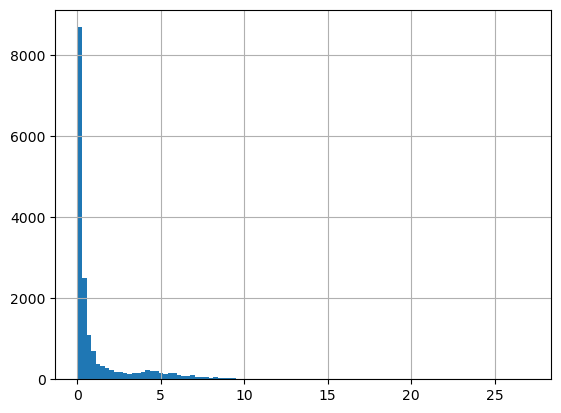

In [10]:
variance.hist(bins=100);

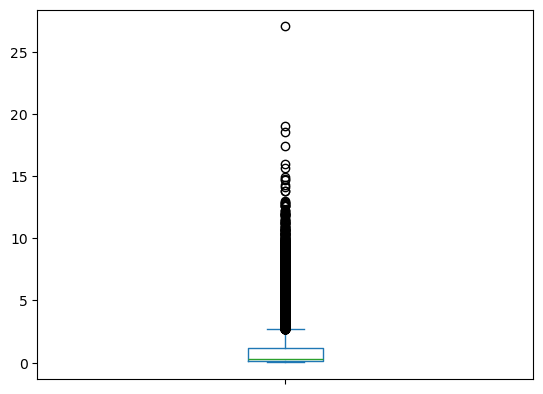

In [11]:
variance.plot.box();

In [12]:
variance.describe()

count    17396.000000
mean         1.262630
std          2.072506
min          0.021771
25%          0.138502
50%          0.293255
75%          1.149937
max         27.036334
dtype: float64

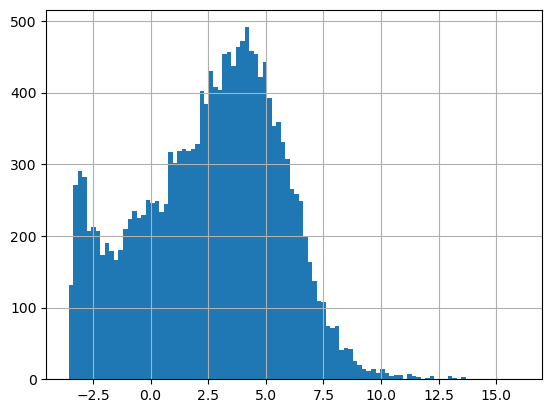

In [13]:
mean.hist(bins=100);

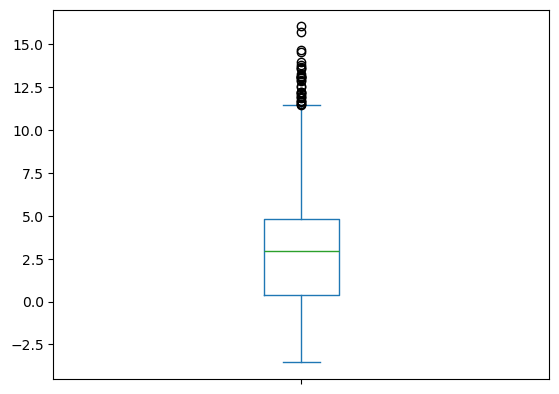

In [14]:
mean.plot.box();

In [15]:
mean.describe()

count    17396.000000
mean         2.576284
std          3.029053
min         -3.541193
25%          0.364225
50%          2.917500
75%          4.790786
max         16.017372
dtype: float64

In [6]:
y.describe()

count        192
unique         3
top       Normal
freq          74
Name: Simplified_class, dtype: object

## Feature Selection Based On Variance

In [16]:
from sklearn.feature_selection import VarianceThreshold

# Apply Variance Threshold with the 25th percentile value
threshold = 0.138502  # 25th percentile
selector = VarianceThreshold(threshold=threshold)
X_reduced = selector.fit_transform(X)

print(f"Number of features before filtering: {X.shape[1]}")
print(f"Number of features after filtering: {X_reduced.shape[1]}")


Number of features before filtering: 17396
Number of features after filtering: 13013


In [28]:
selector.feature_names_in_

array(['ENSG00000000003', 'ENSG00000000005', 'ENSG00000000419', ...,
       'ENSG00000273259', 'ENSG00000273274', 'ENSG00000273294'],
      dtype=object)

## Feature Selection Based On Difference In Expression

In [36]:
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.multitest import multipletests

filtered_data = pd.DataFrame(X_reduced, columns=X.columns[selector.get_support()])
filtered_data['group'] = y.values
# Perform ANOVA for each gene
anova_results = {}

for gene in filtered_data.columns[:-1]:
    model = ols(f'{gene} ~ C(group)', data=filtered_data).fit()
    anova_table = anova_lm(model, typ=2)
    anova_results[gene] = anova_table['PR(>F)'][0]  # p-value for the group effect

# Convert to DataFrame
anova_results_df = pd.DataFrame.from_dict(anova_results, orient='index', columns=['pval'])

# Apply multiple testing correction
anova_results_df['adj_pval'] = multipletests(anova_results_df['pval'], method='fdr_bh')[1]

# Filter for significant genes
significant_genes = anova_results_df[anova_results_df['adj_pval'] < 0.05]
significant_genes

,pval,adj_pval
ENSG00000000003,1.254590e-11,2.776999e-11
ENSG00000000005,1.454911e-03,1.826253e-03
ENSG00000000460,3.003920e-02,3.437262e-02
ENSG00000000938,3.473328e-02,3.951601e-02
ENSG00000000971,1.711343e-15,5.563255e-15
...,...,...
ENSG00000272869,6.335097e-06,9.347841e-06
ENSG00000273079,2.063924e-17,8.849370e-17
ENSG00000273173,2.203881e-10,4.460202e-10
ENSG00000273274,2.536625e-21,4.115848e-20


In [40]:
X_reduced = pd.DataFrame(X_reduced, columns=X.columns[selector.get_support()])
X_reduced[significant_genes.index.values]

,ENSG00000000003,ENSG00000000005,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001084,ENSG00000001167,ENSG00000001460,ENSG00000001617,ENSG00000001626,...,ENSG00000272268,ENSG00000272305,ENSG00000272414,ENSG00000272442,ENSG00000272658,ENSG00000272869,ENSG00000273079,ENSG00000273173,ENSG00000273274,ENSG00000273294
0,5.965571,1.612375,4.150662,2.975845,11.005488,6.825329,4.221450,2.884834,2.213457,4.111056,...,1.823142,0.265925,-0.005377,1.546032,1.365460,0.691230,5.637483,-0.005377,2.683536,-0.339797
1,5.741587,2.147793,3.732756,3.199989,10.860700,6.453687,4.218183,3.199989,2.543722,4.580753,...,1.600305,0.101500,-0.515172,1.806756,0.935490,1.004202,5.975612,0.532134,2.926666,0.435919
2,5.996891,0.418542,3.634637,2.949733,10.934025,6.437658,3.736947,2.683041,2.373873,4.316018,...,0.615578,-0.184123,-0.546693,1.127079,0.675699,0.943633,5.531648,-0.184123,2.260662,-0.691083
3,5.551919,0.702492,3.853979,2.991061,10.760445,6.710840,4.003661,2.991061,2.712760,3.601115,...,1.722956,-0.178864,2.538993,1.301129,0.702492,0.431190,5.571799,-0.034474,2.341393,0.096771
4,6.430237,1.215978,3.614220,2.836130,11.491427,7.437655,4.377965,1.794991,2.189011,3.821572,...,0.898496,-0.079478,-1.216981,0.161530,0.898496,0.085581,5.636848,-1.216981,1.351861,-0.079478
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,6.360397,0.886550,3.336802,2.911496,11.658711,7.384726,4.627703,0.669738,1.568809,2.791202,...,-4.539715,-0.452252,1.526374,-0.632825,-0.147398,-1.080284,2.975985,0.589568,-0.839275,-0.016153
188,6.367705,-0.902201,3.982071,2.202136,11.864397,7.326297,4.528530,0.972268,1.340655,3.067425,...,-2.001737,-0.054204,0.918829,-0.165235,0.048889,-1.108652,3.218814,-0.416774,-1.639167,0.145105
189,6.604050,-0.865036,3.143138,4.037476,11.782524,8.468526,5.013154,1.033084,1.652812,2.214691,...,-4.324468,-0.417577,-2.002540,-0.076540,-1.154543,-0.624028,2.050571,-1.517113,-4.324468,0.067849
190,6.514539,-1.588749,2.741172,2.803568,11.474777,7.617180,4.778544,1.218606,1.470144,3.105512,...,-3.173712,-0.851784,1.349850,-1.058235,-0.114818,-0.510747,2.572243,0.667591,-3.173712,1.218606


In [41]:
DEG_data = X_reduced[significant_genes.index.values].copy()
DEG_data['group'] = y
DEG_data.to_csv('feature_selected_data.csv')